In [11]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt


In [12]:

# ---------------------------
# 1. Data Loading and Preprocessing
# ---------------------------
def parse_path(path_str):
    """Convert a string like '0000011111' to a numpy array of integers."""
    return np.array([int(ch) for ch in path_str.strip()])

def process_record(record):
    """
    Process one data record.
    Uses the three "path" fields (lambda_path, mu_path, nu_path) to form a feature vector.
    The label is 1 if lr_coefficient is nonzero and 0 otherwise.
    """
    lam = parse_path(record["lambda_path"])
    mu  = parse_path(record["mu_path"])
    nu  = parse_path(record["nu_path"])
    # Concatenate the three partition vectors (if each is length 10, total length = 30)
    x = np.concatenate([lam, mu, nu]).astype(np.float32)
    y = 1 if record["lr_coefficient"] != 0 else 0
    return x, y

# Load dataset from JSON file
with open("lr_coefficients_matrix.json", "r") as f:
    data = json.load(f)

# Process all records into a feature matrix X and labels y
X_list, y_list = zip(*[process_record(rec) for rec in data])
X = np.stack(X_list)
y = np.array(y_list).astype(np.float32)


In [13]:

# ---------------------------
# 2. PyTorch Dataset and DataLoader
# ---------------------------
class LRDataset(Dataset):
    def __init__(self, X, y):
        # Normalize features (zero mean, unit variance)
        self.X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-8)
        self.y = y.reshape(-1, 1)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

full_dataset = LRDataset(X, y)

# Split the dataset: 80% training, 20% testing
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [14]:

# ---------------------------
# 3. Define the Neural Network Model
# ---------------------------
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # output: single logit for binary classification
        )
    
    def forward(self, x):
        return self.model(x)

input_dim = X.shape[1]  # e.g., 30 if each path has length 10
model = SimpleMLP(input_dim)


In [15]:

# ---------------------------
# 4. Training Setup with Accuracy Reporting
# ---------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 60

def compute_accuracy(loader, model):
    """Helper function to compute accuracy for a given DataLoader."""
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in loader:
            outputs = model(batch_X)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
    return correct / total


Epoch 1/60: Loss = 0.1473, Train Acc = 93.82%, Test Acc = 93.77%
Epoch 2/60: Loss = 0.1473, Train Acc = 94.03%, Test Acc = 93.95%
Epoch 3/60: Loss = 0.1471, Train Acc = 94.06%, Test Acc = 93.85%
Epoch 4/60: Loss = 0.1470, Train Acc = 94.12%, Test Acc = 94.07%
Epoch 5/60: Loss = 0.1469, Train Acc = 94.16%, Test Acc = 94.09%
Epoch 6/60: Loss = 0.1465, Train Acc = 94.16%, Test Acc = 94.08%
Epoch 7/60: Loss = 0.1466, Train Acc = 94.10%, Test Acc = 93.96%
Epoch 8/60: Loss = 0.1464, Train Acc = 94.00%, Test Acc = 93.86%
Epoch 9/60: Loss = 0.1465, Train Acc = 94.11%, Test Acc = 93.99%
Epoch 10/60: Loss = 0.1463, Train Acc = 94.13%, Test Acc = 94.01%
Epoch 11/60: Loss = 0.1461, Train Acc = 94.14%, Test Acc = 93.98%
Epoch 12/60: Loss = 0.1459, Train Acc = 94.18%, Test Acc = 94.02%
Epoch 13/60: Loss = 0.1457, Train Acc = 93.98%, Test Acc = 93.77%
Epoch 14/60: Loss = 0.1453, Train Acc = 93.99%, Test Acc = 93.86%
Epoch 15/60: Loss = 0.1455, Train Acc = 94.11%, Test Acc = 94.01%
Epoch 16/60: Loss =

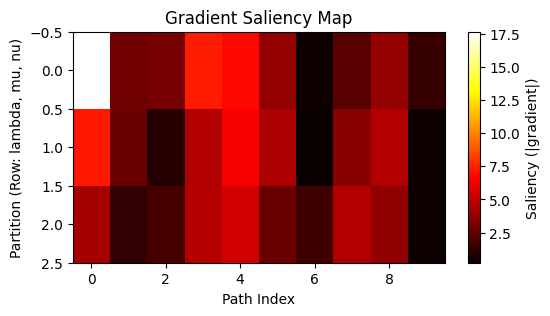

In [20]:

# ---------------------------
# 5. Training Loop
# ---------------------------

loss_curve = []
train_acc_curve = []
test_acc_curve = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(train_dataset)
    loss_curve.append(epoch_loss)

    train_acc = compute_accuracy(train_loader, model)
    test_acc  = compute_accuracy(test_loader, model)

    train_acc_curve.append(train_acc)
    test_acc_curve.append(test_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Loss = {epoch_loss:.4f}, Train Acc = {train_acc*100:.2f}%, Test Acc = {test_acc*100:.2f}%")

# ---------------------------
# 6. Saliency Analysis
# ---------------------------
# After training, select one sample (e.g. from the test set) for saliency analysis.
model.eval()
sample_X, sample_y = test_dataset[0]
sample_X = sample_X.unsqueeze(0)  # add batch dimension

# Enable gradient tracking on the input
sample_X.requires_grad = True

# Forward pass
output = model(sample_X)
# Compute gradients of the output with respect to the input
output.backward()

# Absolute gradient values as saliency scores
saliency = sample_X.grad.data.abs().numpy().squeeze()

# Reshape saliency into a 3 x (path_length) matrix (assumes each path has equal length)
path_length = parse_path(data[0]["lambda_path"]).shape[0]
saliency_matrix = saliency.reshape(3, path_length)

# Plot the saliency heatmap
plt.figure(figsize=(6, 3))
plt.imshow(saliency_matrix, cmap="hot", aspect="auto")
plt.colorbar(label="Saliency (|gradient|)")
plt.xlabel("Path Index")
plt.ylabel("Partition (Row: lambda, mu, nu)")
plt.title("Gradient Saliency Map")
plt.show()


In [19]:
import numpy as np
import torch

def parse_path(path_str):
    """Convert a string like '0000011111' to a numpy array of integers."""
    return np.array([int(ch) for ch in path_str.strip()])

def predict_partition_triplet(lambda_path, mu_path, nu_path, model, mean, std):
    """
    Given three partition path strings, preprocess them, and use the model to predict.
    
    Parameters:
        lambda_path, mu_path, nu_path (str): e.g., "0000011111"
        model (torch.nn.Module): Trained PyTorch model.
        mean (np.array): Mean vector (shape: [input_dim]) from training.
        std (np.array): Standard deviation vector from training.
        
    Returns:
        pred (int): Predicted class (0 or 1).
        prob (float): Predicted probability (after sigmoid).
    """
    # Parse each path to obtain numeric vectors.
    lam = parse_path(lambda_path)
    mu  = parse_path(mu_path)
    nu  = parse_path(nu_path)
    # Concatenate to form a single feature vector.
    x = np.concatenate([lam, mu, nu]).astype(np.float32)
    
    # Normalize using provided mean and std.
    x_norm = (x - mean) / (std + 1e-8)
    
    # Convert to tensor and add a batch dimension.
    x_tensor = torch.tensor(x_norm, dtype=torch.float32).unsqueeze(0)
    
    # Put the model in evaluation mode and get prediction.
    model.eval()
    with torch.no_grad():
        output = model(x_tensor)  # raw logits
        prob = torch.sigmoid(output).item()
        pred = 1 if prob >= 0.5 else 0
    return pred, prob

# --- Example usage ---
# Replace these with the actual mean and std from your training data.
# For example, if each input has dimension 30, these should be arrays of length 30.
global_mean = np.zeros(30)  # dummy placeholder; replace with your actual mean vector
global_std  = np.ones(30)   # dummy placeholder; replace with your actual std vector

# Example partition triplet (strings as in your dataset)
lambda_path = "0010011111"
mu_path     = "0100011111"
nu_path     = "1000101111"

# Assume 'model' is your trained model (e.g., an instance of SimpleMLP)
# For demonstration, if 'model' is not defined, you must load or define it.
# Here, we assume it is already available in the workspace.
prediction, probability = predict_partition_triplet(lambda_path, mu_path, nu_path, model, global_mean, global_std)
print("Prediction:", prediction)
print("Probability:", probability)


Prediction: 0
Probability: 0.0008141567814163864


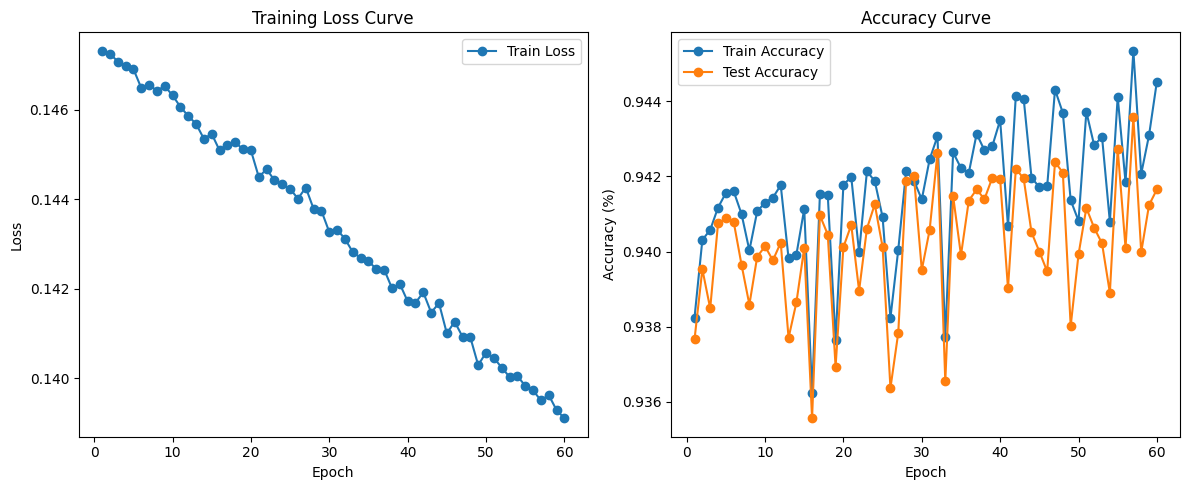

In [21]:

epochs = range(1, len(loss_curve) + 1)

plt.figure(figsize=(12, 5))

# Plot the loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_curve, marker='o', label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# Plot the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_curve, marker='o', label="Train Accuracy")
plt.plot(epochs, test_acc_curve, marker='o', label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()
